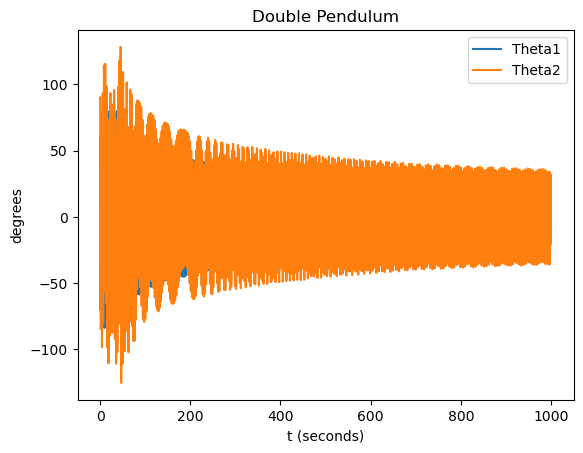

Train RMSE: 0.006124306144592634
Test RMSE: 0.015445132709464304
Train R^2 Score: 0.9975916755231962
Test R^2 Score: 0.9856719475761813


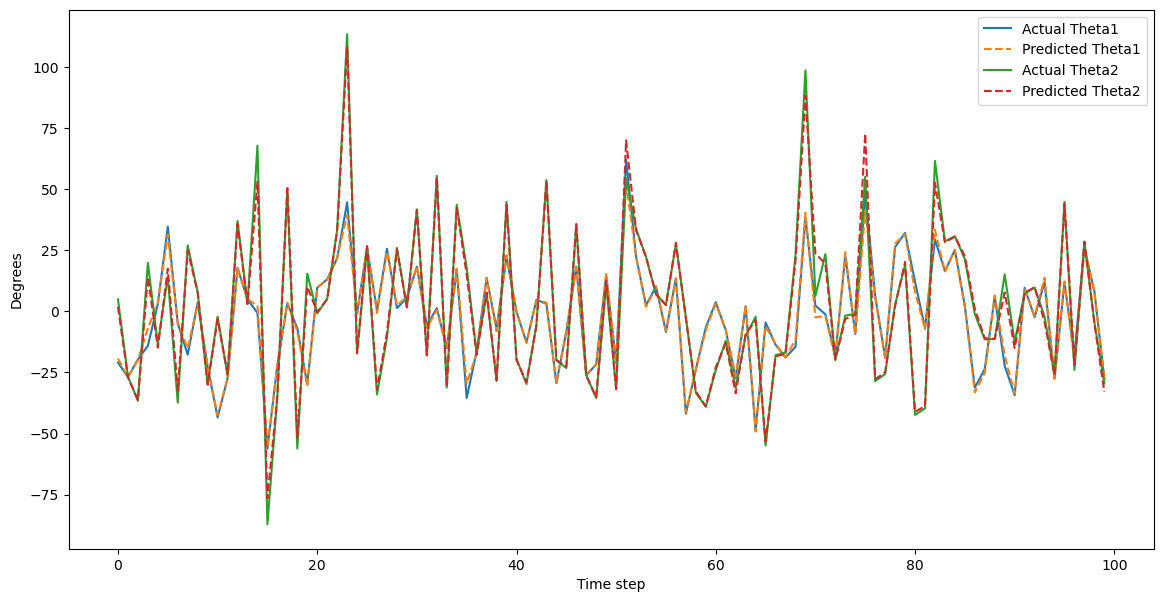

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import array

# Constants
g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0

# Differential equation solver
def f(r, t, L1, L2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]

    ftheta1 = omega1
    fomega1 = (-g * (2 * m1 + m2) * sin(theta1) - m2 * g * sin(theta1 - 2 * theta2) - 2 * sin(theta1 - theta2) * m2 * 
               (omega2**2 * L2 + omega1**2 * L1 * cos(theta1 - theta2))) / (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    ftheta2 = omega2
    fomega2 = (2 * sin(theta1 - theta2) * (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * cos(theta1) + omega2**2 * L2 * m2 * 
                                           cos(theta1 - theta2))) / (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    return array([ftheta1, fomega1, ftheta2, fomega2], float)

# Time parameters
a = 0.0
b = 1000
N = 10000
h = (b - a) / N

# Arrays to store results
tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)
theta2_points = np.zeros_like(tpoints)

# Initial conditions
q = np.array([pi / 3, 0, pi / 2, 0], float)

for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / pi  # Convert to degrees
    theta2_points[i] = q[2] * 180 / pi

    k1 = h * f(q, t, L1, L2)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h, L1, L2)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h, L1, L2)
    k4 = h * f(q + k3, t + h, L1, L2)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Plot the data
plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.title("Double Pendulum")
plt.xlabel("t (seconds)")
plt.ylabel("degrees")
plt.legend()
plt.show()

# Combine the data
data = np.stack((theta1_points, theta2_points), axis=1)
np.save('pendulum_data.npy', data)

# Load the data
data = np.load('pendulum_data.npy')

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Create features and labels for regression
def create_features(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length].flatten()  # Flatten to create a single feature vector
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50
X, y = create_features(data, SEQ_LENGTH)

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=42)

model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_pred)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train R^2 Score: {train_r2}')
print(f'Test R^2 Score: {test_r2}')

y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# Plotting the training and testing loss
train_losses = model.estimators_[0].oob_improvement_ if hasattr(model.estimators_[0], 'oob_improvement_') else [train_mse] * len(model.estimators_)
test_losses = [mean_squared_error(y_test, model.estimators_[i].predict(X_test)) for i in range(len(model.estimators_))]
time_steps_to_plot = 100  # Number of time steps to plot

plt.figure(figsize=(14, 7))
plt.plot(y_test_original[:time_steps_to_plot, 0], label='Actual Theta1')
plt.plot(y_pred_original[:time_steps_to_plot, 0], label='Predicted Theta1', linestyle='dashed')
plt.plot(y_test_original[:time_steps_to_plot, 1], label='Actual Theta2')
plt.plot(y_pred_original[:time_steps_to_plot, 1], label='Predicted Theta2', linestyle='dashed')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()




Mean Squared Error: 43.34730186562025
R^2 Score: 0.9995406159554718
Predicted angles (original scale): [[  54.29630241 -345.40603299]
 [  52.01481726 -622.87885435]
 [  53.65371387 -363.80507337]
 ...
 [  30.24175951 -807.1110148 ]
 [  29.8884532  -812.04290641]
 [  30.18610069 -810.93296041]]
Generated coordinates: [(0.8120458663083483, -0.5835936180352935, 1.0640133276239283, -1.5513293249502453), (0.7881699434427798, -0.6154576673122248, 1.7804561972332724, -0.49148996773515785), (0.8054497642610451, -0.592664050919091, 0.7390875118370885, -1.5904596469472652), (0.781317345920536, -0.6241339639562082, 1.7121038402416449, -0.2585706972164816), (0.8000596888746749, -0.5999204065855389, 0.6390906995727464, -1.586879871043485)]


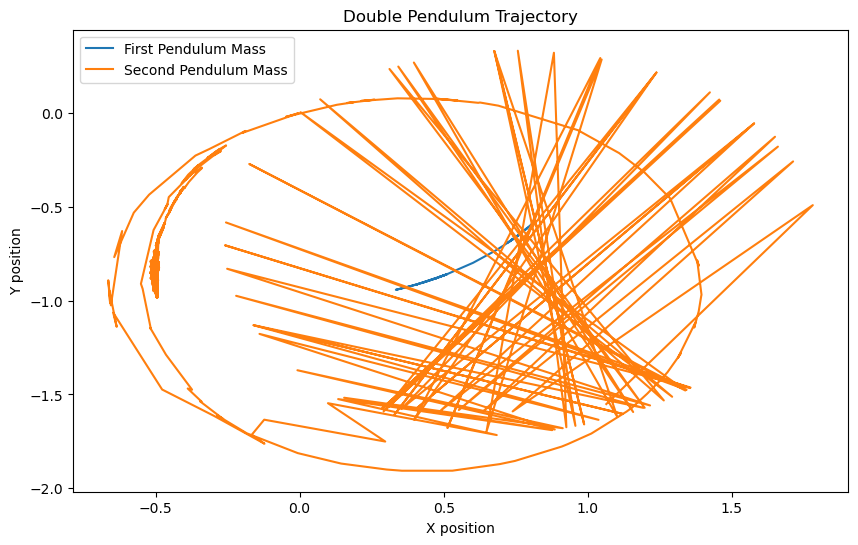

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load and normalize data
data = np.load('pendulum_data.npy')
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Create features and labels for regression
def create_features(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length].flatten()  # Flatten to create a single feature vector
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50
X, y = create_features(data, SEQ_LENGTH)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# Evaluate model performance
mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Function to convert angles to (x, y) coordinates
def get_coordinates(theta1, theta2, L1, L2):
    x1 = L1 * sin(theta1 * pi / 180)  # Convert degrees to radians
    y1 = -L1 * cos(theta1 * pi / 180)
    x2 = x1 + L2 * sin(theta2 * pi / 180)
    y2 = y1 - L2 * cos(theta2 * pi / 180)
    return x1, y1, x2, y2

# Use the first sequence of the test set for generating the trajectory
initial_sequence = X_test[0].reshape(1, -1)  # Reshape to 2D array for prediction

# Generate a sequence of predictions
predicted_sequence = initial_sequence
predicted_angles = []

for _ in range(len(data) - SEQ_LENGTH):
    next_prediction = model.predict(predicted_sequence[-1].reshape(1, -1))
    # Shift the window to keep the length fixed
    predicted_sequence = np.roll(predicted_sequence, -1, axis=1)
    predicted_sequence[:, -2:] = next_prediction.reshape(1, -1)
    predicted_angles.append(next_prediction[0])

predicted_angles = np.array(predicted_angles)
predicted_sequence_original = scaler.inverse_transform(predicted_angles)

print("Predicted angles (original scale):", predicted_sequence_original)

# Generate coordinates for the plot
coords = [get_coordinates(theta1, theta2, 1, 1) for theta1, theta2 in predicted_sequence_original]
print("Generated coordinates:", coords[:5])  # Print the first 5 coordinates for verification

# Extract x and y coordinates for plotting
x1_vals = [coord[0] for coord in coords]
y1_vals = [coord[1] for coord in coords]
x2_vals = [coord[2] for coord in coords]
y2_vals = [coord[3] for coord in coords]

# Plot the trajectory
plt.figure(figsize=(10, 6))
plt.plot(x1_vals, y1_vals, label='First Pendulum Mass')
plt.plot(x2_vals, y2_vals, label='Second Pendulum Mass')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Double Pendulum Trajectory')
plt.legend()
plt.show()
